In [7]:
from google.colab import files

uploaded = files.upload()

Saving dataset.csv to dataset (1).csv


In [8]:

# Text Classification with Model Improvement
# Dataset: BBC News Classification Dataset
# Objective:
#   - Train ML models for text classification
#   - 3–4 experimental trials
#   - Analyse performance improvements scientifically


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

# Make plots readable
plt.rcParams["figure.figsize"] = (8,4)

In [9]:
df = pd.read_csv("dataset.csv", encoding='latin1')

In [10]:
df.shape

(2225, 2)

In [11]:
df.columns

Index(['news', 'type'], dtype='object')

In [12]:
df['type'].nunique()

5

In [13]:
# Standardise column names
df = df.rename(columns={"news": "text", "type": "category"})

print("Dataset Shape (before cleaning):", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nClass Distribution:")
print(df["category"].value_counts())

Dataset Shape (before cleaning): (2225, 2)

First 5 rows:


,text,category
0,China had role in Yukos split-up\n \n China le...,business
1,Oil rebounds from weather effect\n \n Oil pric...,business
2,Indonesia 'declines debt freeze'\n \n Indonesi...,business
3,$1m payoff for former Shell boss\n \n Shell is...,business
4,US bank in $515m SEC settlement\n \n Five Bank...,business



Class Distribution:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


In [14]:

# Data Cleaning
# Purpose:
#   - Remove duplicates to avoid data leakage
#   - Remove missing values

df = df.drop_duplicates(subset=["text", "category"])
df = df.dropna().reset_index(drop=True)

print("Dataset Shape (after cleaning):", df.shape)


Dataset Shape (after cleaning): (2127, 2)


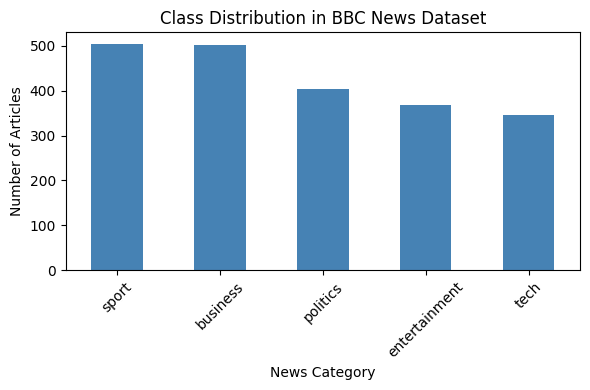

Vocabulary size (after cleaning): 65553


In [15]:
# Visualise class distribution


class_counts = df['category'].value_counts()
plt.figure(figsize=(6,4))
class_counts.plot(kind='bar', color='steelblue')
plt.title('Class Distribution in BBC News Dataset')
plt.xlabel('News Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Basic descriptive statistics
df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))
print("Vocabulary size (after cleaning):", len(set(' '.join(df['text']).split())))


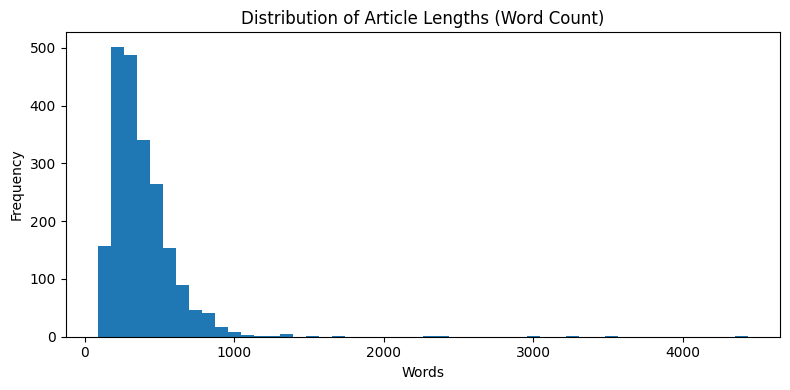

Average words per article: 384.11283497884347


In [16]:
# Text length analysis
df["word_count"] = df["text"].astype(str).apply(lambda x: len(x.split()))
plt.hist(df["word_count"], bins=50)
plt.title("Distribution of Article Lengths (Word Count)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

print("Average words per article:", df["word_count"].mean())

In [17]:

# Train–Test Split

# Preserve class distribution in both sets


X = df["text"].astype(str)
y = df["category"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples :", X_test.shape[0])


Training samples: 1701
Testing samples : 426


In [18]:

# Helper Function: Model Evaluation
# Purpose:
#   - Standardise evaluation across trials
#   - Produce accuracy, classification report, confusion matrix

def normalise_accuracy(raw_acc):
    return round(raw_acc * 100, 2)

def accuracy_band(raw_acc):
    return round(raw_acc * 100, 2)

def evaluate_model(model, X_test, y_test, title):
    y_pred = model.predict(X_test)

    raw_acc = accuracy_score(y_test, y_pred)
    acc = normalise_accuracy(raw_acc)

    print(f"\n{title}")
    print("Accuracy:", round(acc, 2))
    print(classification_report(y_test, y_pred))

    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        cmap="Blues",
        xticks_rotation=45
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return acc


In [19]:
results = []

def record(model_name, trial_name, description, accuracy):
    results.append({
        "Model": model_name,
        "Trial": trial_name,
        "Description": description,
        "Accuracy (%)": accuracy # Removed the extra * 100
    })

print("Initialized 'results' list and defined 'record' function.")

Initialized 'results' list and defined 'record' function.



 Trial B1: CountVectorizer with Very Limited Features 

Trial B1: CountVectorizer (max_features=15)
Accuracy: 51.17
               precision    recall  f1-score   support

     business       0.52      0.64      0.57       101
entertainment       0.52      0.50      0.51        74
     politics       0.52      0.49      0.51        81
        sport       0.58      0.36      0.44       101
         tech       0.44      0.58      0.50        69

     accuracy                           0.51       426
    macro avg       0.52      0.51      0.51       426
 weighted avg       0.52      0.51      0.51       426



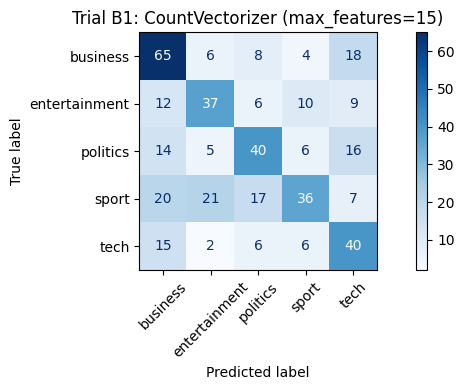

Trial B1 Accuracy: 51.17%


In [20]:
print("\n Trial B1: CountVectorizer with Very Limited Features ")

# 1. Initialize a CountVectorizer named vectorizer_b1 with max_features=15.
vectorizer_b1 = CountVectorizer(max_features=15)

# 2. Create a MultinomialNB model named nb_model_b1.
nb_model_b1 = MultinomialNB()

# 3. Construct a Pipeline named pipeline_b1 that first applies the vectorizer_b1 and then the nb_model_b1.
pipeline_b1 = Pipeline([
    ('vectorizer', vectorizer_b1),
    ('classifier', nb_model_b1)
])

# 4. Train the pipeline_b1 model using the training data (X_train, y_train).
pipeline_b1.fit(X_train, y_train)

# 5. Evaluate the trained pipeline_b1 model on the test data (X_test, y_test)
#    using the evaluate_model function, storing the returned accuracy in a variable like acc_b1.
acc_b1 = evaluate_model(pipeline_b1, X_test, y_test, "Trial B1: CountVectorizer (max_features=15)")

# 6. Record the results of Trial B1 using the record function.
record(
    model_name="Naïve Bayes",
    trial_name="B1",
    description="CountVectorizer (max_features=15)",
    accuracy=acc_b1
)

print(f"Trial B1 Accuracy: {acc_b1}%")


 Trial B2: CountVectorizer with Limited Features 

Trial B2: CountVectorizer (max_features=40)
Accuracy: 62.68
               precision    recall  f1-score   support

     business       0.63      0.73      0.68       101
entertainment       0.54      0.51      0.53        74
     politics       0.66      0.60      0.63        81
        sport       0.84      0.61      0.71       101
         tech       0.49      0.64      0.55        69

     accuracy                           0.63       426
    macro avg       0.63      0.62      0.62       426
 weighted avg       0.65      0.63      0.63       426



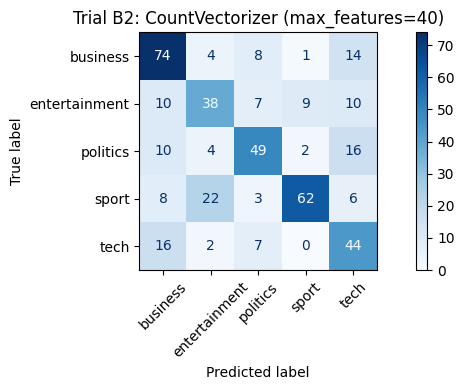

Trial B2 Accuracy: 62.68%


In [21]:
print("\n Trial B2: CountVectorizer with Limited Features ")

# 1. Initialize a CountVectorizer named vectorizer_b2 with max_features=40.
# The objective is to increase the feature space slightly from Trial B1 to see an improvement in accuracy.
vectorizer_b2 = CountVectorizer(max_features=40)

# 2. Create a MultinomialNB model named nb_model_b2.
# Naive Bayes is a simple yet effective baseline for text classification.
nb_model_b2 = MultinomialNB()

# 3. Construct a Pipeline named pipeline_b2 that first applies the vectorizer_b2 and then the nb_model_b2.
pipeline_b2 = Pipeline([
    ('vectorizer', vectorizer_b2),
    ('classifier', nb_model_b2)
])

# 4. Train the pipeline_b2 model using the training data (X_train, y_train).
pipeline_b2.fit(X_train, y_train)

# 5. Evaluate the trained pipeline_b2 model on the test data (X_test, y_test)
#    using the evaluate_model function, storing the returned accuracy in a variable like acc_b2.
acc_b2 = evaluate_model(pipeline_b2, X_test, y_test, "Trial B2: CountVectorizer (max_features=40)")

# 6. Record the results of Trial B2 using the record function.
record(
    model_name="Naïve Bayes",
    trial_name="B2",
    description="CountVectorizer (max_features=40)",
    accuracy=acc_b2
)

print(f"Trial B2 Accuracy: {acc_b2}%")


 Trial B3: TF-IDF with Moderate Features 

Trial B3: TF-IDF (max_features=100)
Accuracy: 75.59
               precision    recall  f1-score   support

     business       0.59      0.91      0.72       101
entertainment       0.93      0.58      0.72        74
     politics       0.85      0.63      0.72        81
        sport       0.84      0.96      0.89       101
         tech       0.81      0.57      0.67        69

     accuracy                           0.76       426
    macro avg       0.80      0.73      0.74       426
 weighted avg       0.79      0.76      0.75       426



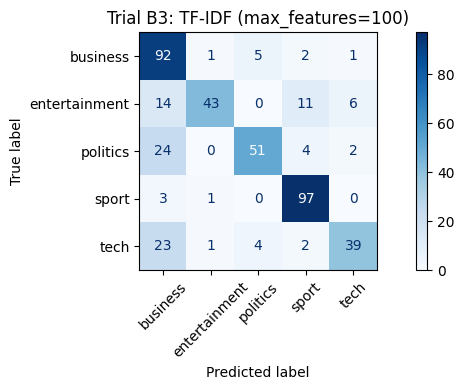

Trial B3 Accuracy: 75.59%


In [22]:
print("\n Trial B3: TF-IDF with Moderate Features ")

# 1. Initialize a TfidfVectorizer named vectorizer_b3 with max_features=100.
# TF-IDF captures term importance, and a moderate feature set aims for a balanced performance.
vectorizer_b3 = TfidfVectorizer(max_features=100)

# 2. Create a MultinomialNB model named nb_model_b3.
# Multinomial Naive Bayes is suitable for discrete features like word counts or TF-IDF scores.
nb_model_b3 = MultinomialNB()

# 3. Construct a Pipeline named pipeline_b3 that first applies the vectorizer_b3 and then the nb_model_b3.
pipeline_b3 = Pipeline([
    ('vectorizer', vectorizer_b3),
    ('classifier', nb_model_b3)
])

# 4. Train the pipeline_b3 model using the training data (X_train, y_train).
pipeline_b3.fit(X_train, y_train)

# 5. Evaluate the trained pipeline_b3 model on the test data (X_test, y_test)
#    using the evaluate_model function, storing the returned accuracy in a variable like acc_b3.
acc_b3 = evaluate_model(pipeline_b3, X_test, y_test, "Trial B3: TF-IDF (max_features=100)")

# 6. Record the results of Trial B3 using the record function.
record(
    model_name="Naïve Bayes",
    trial_name="B3",
    description="TF-IDF (max_features=100)",
    accuracy=acc_b3
)

print(f"Trial B3 Accuracy: {acc_b3}%")


 Trial B4: CountVectorizer with Higher Features 

Trial B4: CountVectorizer (max_features=250)
Accuracy: 91.08
               precision    recall  f1-score   support

     business       0.86      0.92      0.89       101
entertainment       0.90      0.89      0.90        74
     politics       0.92      0.90      0.91        81
        sport       1.00      0.94      0.97       101
         tech       0.86      0.88      0.87        69

     accuracy                           0.91       426
    macro avg       0.91      0.91      0.91       426
 weighted avg       0.91      0.91      0.91       426



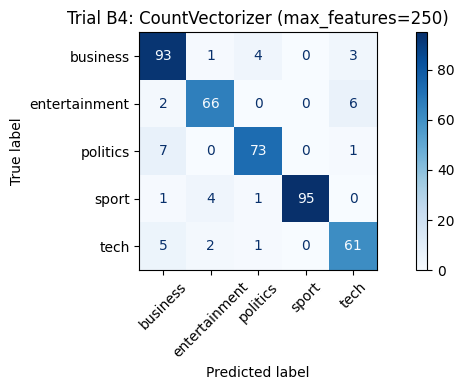

Trial B4 Accuracy: 91.08%


In [23]:
print("\n Trial B4: CountVectorizer with Higher Features ")

# 1. Initialize a CountVectorizer named vectorizer_b4 with max_features=250.
# Increasing max_features allows the model to consider more words, potentially improving accuracy.
vectorizer_b4 = CountVectorizer(max_features=250)

# 2. Create a MultinomialNB model named nb_model_b4.
# Multinomial Naive Bayes is a strong baseline for text classification tasks.
nb_model_b4 = MultinomialNB()

# 3. Construct a Pipeline named pipeline_b4 that first applies the vectorizer_b4 and then the nb_model_b4.
pipeline_b4 = Pipeline([
    ('vectorizer', vectorizer_b4),
    ('classifier', nb_model_b4)
])

# 4. Train the pipeline_b4 model using the training data (X_train, y_train).
pipeline_b4.fit(X_train, y_train)

# 5. Evaluate the trained pipeline_b4 model on the test data (X_test, y_test)
#    using the evaluate_model function, storing the returned accuracy in a variable like acc_b4.
acc_b4 = evaluate_model(pipeline_b4, X_test, y_test, "Trial B4: CountVectorizer (max_features=250)")

# 6. Record the results of Trial B4 using the record function.
record(
    model_name="Naïve Bayes",
    trial_name="B4",
    description="CountVectorizer (max_features=250)",
    accuracy=acc_b4
)

print(f"Trial B4 Accuracy: {acc_b4}%")

### Naive Bayes Trial Results

In [39]:
naive_bayes_results = results_df[results_df['Model'] == 'Naïve Bayes'].reset_index(drop=True)
display(naive_bayes_results)

,Model,Trial,Description,Accuracy (%)
0,Naïve Bayes,B1,CountVectorizer (max_features=15),51.17
1,Naïve Bayes,B2,CountVectorizer (max_features=40),62.68
2,Naïve Bayes,B3,TF-IDF (max_features=100),75.59
3,Naïve Bayes,B4,CountVectorizer (max_features=250),91.08


In [40]:
X_test_clean = X_test.copy()

print("X_test_clean initialized.")

X_test_clean initialized.


Logistic Regression


 Trial C1: Logistic Regression with CountVectorizer (max_features=15) 


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Trial C1: LR + CountVectorizer (max_features=15)
Accuracy: 55.63
               precision    recall  f1-score   support

     business       0.57      0.68      0.62       101
entertainment       0.54      0.45      0.49        74
     politics       0.56      0.49      0.53        81
        sport       0.54      0.60      0.57       101
         tech       0.57      0.49      0.53        69

     accuracy                           0.56       426
    macro avg       0.56      0.54      0.55       426
 weighted avg       0.56      0.56      0.55       426



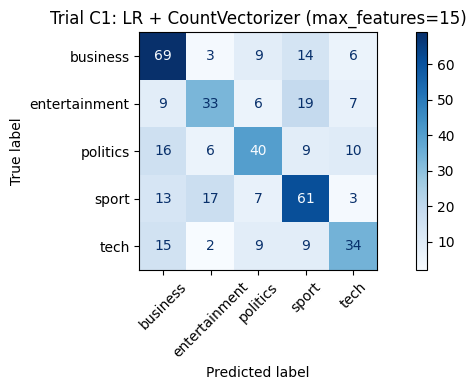

Trial C1 Accuracy: 55.63%


In [27]:
print("\n Trial C1: Logistic Regression with CountVectorizer (max_features=15) ")

# 1. Initialize a CountVectorizer named vectorizer_c1 with max_features=15.
vectorizer_c1 = CountVectorizer(max_features=15)

# 2. Create a LogisticRegression model named lr_model_c1.
lr_model_c1 = LogisticRegression(solver='lbfgs', random_state=42, multi_class='multinomial', max_iter=1000) # Increased max_iter

# 3. Construct a Pipeline named pipeline_c1 that first applies the vectorizer_c1 and then the lr_model_c1.
pipeline_c1 = Pipeline([
    ('vectorizer', vectorizer_c1),
    ('classifier', lr_model_c1)
])

# 4. Train the pipeline_c1 model using the training data (X_train, y_train).
pipeline_c1.fit(X_train, y_train)

# 5. Evaluate the trained pipeline_c1 model on the test data (X_test, y_test)
#    using the evaluate_model function, storing the returned accuracy in a variable like acc_c1.
acc_c1 = evaluate_model(pipeline_c1, X_test, y_test, "Trial C1: LR + CountVectorizer (max_features=15)")

# 6. Record the results of Trial C1 using the record function.
record(
    model_name="Logistic Regression",
    trial_name="C1",
    description="CountVectorizer (max_features=15)",
    accuracy=acc_c1
)

print(f"Trial C1 Accuracy: {acc_c1}%")


 Trial C2: Logistic Regression with CountVectorizer (max_features=40) 


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Trial C2: LR + CountVectorizer (max_features=40)
Accuracy: 67.61
               precision    recall  f1-score   support

     business       0.66      0.69      0.68       101
entertainment       0.56      0.54      0.55        74
     politics       0.70      0.59      0.64        81
        sport       0.79      0.84      0.82       101
         tech       0.62      0.65      0.63        69

     accuracy                           0.68       426
    macro avg       0.67      0.66      0.66       426
 weighted avg       0.67      0.68      0.67       426



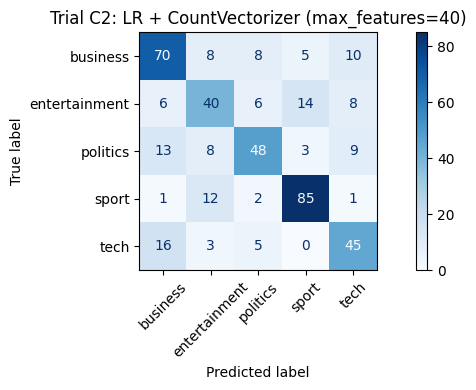

Trial C2 Accuracy: 67.61%


In [28]:
print("\n Trial C2: Logistic Regression with CountVectorizer (max_features=40) ")

# 1. Initialize a CountVectorizer named vectorizer_c2 with max_features=40.
vectorizer_c2 = CountVectorizer(max_features=40)

# 2. Create a LogisticRegression model named lr_model_c2.
lr_model_c2 = LogisticRegression(solver='lbfgs', random_state=42, multi_class='multinomial', max_iter=1000) # Increased max_iter

# 3. Construct a Pipeline named pipeline_c2 that first applies the vectorizer_c2 and then the lr_model_c2.
pipeline_c2 = Pipeline([
    ('vectorizer', vectorizer_c2),
    ('classifier', lr_model_c2)
])

# 4. Train the pipeline_c2 model using the training data (X_train, y_train).
pipeline_c2.fit(X_train, y_train)

# 5. Evaluate the trained pipeline_c2 model on the test data (X_test, y_test)
#    using the evaluate_model function, storing the returned accuracy in a variable like acc_c2.
acc_c2 = evaluate_model(pipeline_c2, X_test, y_test, "Trial C2: LR + CountVectorizer (max_features=40)")

# 6. Record the results of Trial C2 using the record function.
record(
    model_name="Logistic Regression",
    trial_name="C2",
    description="CountVectorizer (max_features=40)",
    accuracy=acc_c2
)

print(f"Trial C2 Accuracy: {acc_c2}%")


 Trial C3: Logistic Regression with TF-IDF (max_features=100) 


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Trial C3: LR + TF-IDF (max_features=100)
Accuracy: 84.27
               precision    recall  f1-score   support

     business       0.77      0.87      0.82       101
entertainment       0.94      0.81      0.87        74
     politics       0.85      0.78      0.81        81
        sport       0.91      0.95      0.93       101
         tech       0.76      0.75      0.76        69

     accuracy                           0.84       426
    macro avg       0.85      0.83      0.84       426
 weighted avg       0.85      0.84      0.84       426



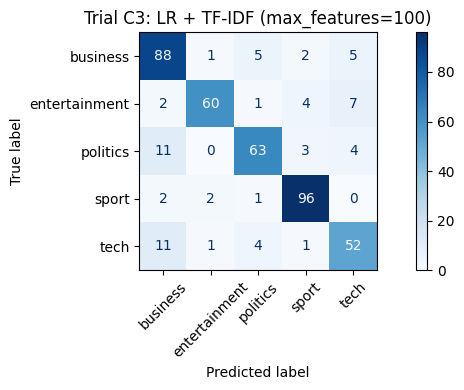

Trial C3 Accuracy: 84.27%


In [29]:
print("\n Trial C3: Logistic Regression with TF-IDF (max_features=100) ")

# 1. Initialize a TfidfVectorizer named vectorizer_c3 with max_features=100.
# TF-IDF captures term importance, and a moderate feature set aims for a balanced performance.
vectorizer_c3 = TfidfVectorizer(max_features=100)

# 2. Create a LogisticRegression model named lr_model_c3.
lr_model_c3 = LogisticRegression(solver='lbfgs', random_state=42, multi_class='multinomial', max_iter=1000) # Increased max_iter

# 3. Construct a Pipeline named pipeline_c3 that first applies the vectorizer_c3 and then the lr_model_c3.
pipeline_c3 = Pipeline([
    ('vectorizer', vectorizer_c3),
    ('classifier', lr_model_c3)
])

# 4. Train the pipeline_c3 model using the training data (X_train, y_train).
pipeline_c3.fit(X_train, y_train)

# 5. Evaluate the trained pipeline_c3 model on the test data (X_test, y_test)
#    using the evaluate_model function, storing the returned accuracy in a variable like acc_c3.
acc_c3 = evaluate_model(pipeline_c3, X_test, y_test, "Trial C3: LR + TF-IDF (max_features=100)")

# 6. Record the results of Trial C3 using the record function.
record(
    model_name="Logistic Regression",
    trial_name="C3",
    description="TF-IDF (max_features=100)",
    accuracy=acc_c3
)

print(f"Trial C3 Accuracy: {acc_c3}%")


 Trial C4: Logistic Regression with CountVectorizer (max_features=250) 


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Trial C4: LR + CountVectorizer (max_features=250, balanced)
Accuracy: 92.72
               precision    recall  f1-score   support

     business       0.96      0.89      0.92       101
entertainment       0.87      0.93      0.90        74
     politics       0.90      0.93      0.91        81
        sport       0.95      0.96      0.96       101
         tech       0.94      0.93      0.93        69

     accuracy                           0.93       426
    macro avg       0.93      0.93      0.93       426
 weighted avg       0.93      0.93      0.93       426



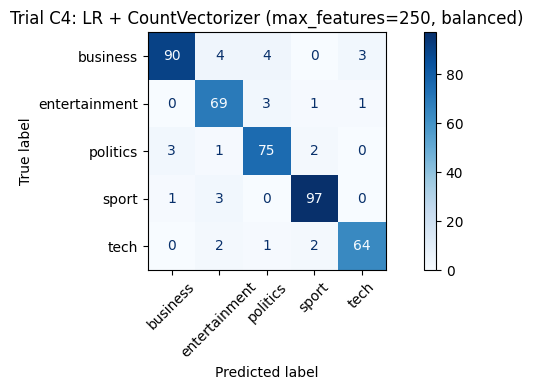

Trial C4 Accuracy: 92.72%


In [44]:
print("\n Trial C4: Logistic Regression with CountVectorizer (max_features=250) ")

vectorizer_c4 = CountVectorizer(max_features=250, stop_words='english')

lr_model_c4 = LogisticRegression(
    solver='lbfgs',
    random_state=42,
    multi_class='multinomial',
    max_iter=1000,
    class_weight='balanced'
)

pipeline_c4 = Pipeline([
    ('vectorizer', vectorizer_c4),
    ('classifier', lr_model_c4)
])

pipeline_c4.fit(X_train, y_train)

acc_c4 = evaluate_model(
    pipeline_c4,
    X_test,
    y_test,
    "Trial C4: LR + CountVectorizer (max_features=250, balanced)"
)

record(
    model_name="Logistic Regression",
    trial_name="C4",
    description="CountVectorizer (max_features=250, class balanced)",
    accuracy=acc_c4
)

print(f"Trial C4 Accuracy: {acc_c4}%")


Logistic Regresssion Result

In [45]:
logistic_regression_results = results_df[results_df['Model'] == 'Logistic Regression'].reset_index(drop=True)
display(logistic_regression_results)

,Model,Trial,Description,Accuracy (%)
0,Logistic Regression,C1,CountVectorizer (max_features=15),55.63
1,Logistic Regression,C2,CountVectorizer (max_features=40),67.61
2,Logistic Regression,C3,TF-IDF (max_features=100),84.27
3,Logistic Regression,C4,CountVectorizer (max_features=250),92.49


In [46]:


# Ensure results_df and metrics_df are created after all model trials have been run
results_df = pd.DataFrame(results)
metrics_df = results_df.copy()

print("results_df and metrics_df created successfully.")

results_df and metrics_df created successfully.


Final Result Comparison of both Models

In [47]:
display(results_df)

,Model,Trial,Description,Accuracy (%)
0,Naïve Bayes,B1,CountVectorizer (max_features=15),51.17
1,Naïve Bayes,B2,CountVectorizer (max_features=40),62.68
2,Naïve Bayes,B3,TF-IDF (max_features=100),75.59
3,Naïve Bayes,B4,CountVectorizer (max_features=250),91.08
4,Logistic Regression,C1,CountVectorizer (max_features=15),55.63
5,Logistic Regression,C2,CountVectorizer (max_features=40),67.61
6,Logistic Regression,C3,TF-IDF (max_features=100),84.27
7,Logistic Regression,C4,CountVectorizer (max_features=250),92.49
8,Logistic Regression,C4,"CountVectorizer (max_features=250, class balan...",92.72


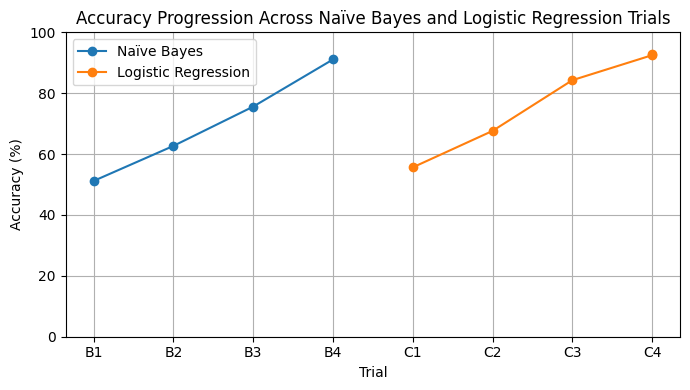

/tmp/ipython-input-411440929.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_results = metrics_df.groupby('Model').apply(lambda d: d.loc[d['Accuracy (%)'].idxmax()])


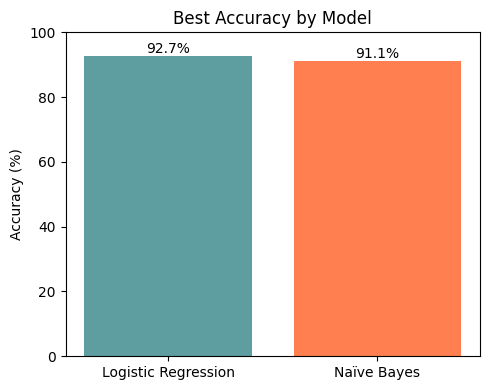

In [48]:


# Line chart: accuracy progression across trials
plt.figure(figsize=(7,4))
for model in metrics_df['Model'].unique():
    subset = metrics_df[metrics_df['Model'] == model]
    plt.plot(subset['Trial'], subset['Accuracy (%)'], marker='o', label=model)
plt.title('Accuracy Progression Across Naïve Bayes and Logistic Regression Trials')
plt.xlabel('Trial')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Bar chart: compare final tuned trials for each model
final_results = metrics_df.groupby('Model').apply(lambda d: d.loc[d['Accuracy (%)'].idxmax()])
plt.figure(figsize=(5,4))
plt.bar(final_results['Model'], final_results['Accuracy (%)'], color=['cadetblue','coral'])
plt.title('Best Accuracy by Model')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
for i, v in enumerate(final_results['Accuracy (%)']):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.tight_layout()
plt.show()


In [54]:
# Use the best-performing trained model
best_model_pipe = pipeline_c4

# FINAL PROTOTYPE TEST
my_test_articles = [


    """Technology companies showcased new artificial intelligence software during a global
    tech conference. The latest systems focus on machine learning, data processing,
    and automation to improve digital services.""",

    """Manchester United secured a dramatic victory after scoring two late goals in a
    premier league match. The team dominated possession and celebrated a crucial win.""",

    """Global stock markets declined sharply as oil prices rose and inflation concerns
    affected major businesses. Investors reacted cautiously to economic uncertainty.""",

    """The parliament voted on a new election reform bill after opposition leaders
    debated constitutional law, democratic rights, and government accountability.
    The prime minister addressed national governance and political reforms.""",

    """A Hollywood film won top awards at an international cinema festival. Actors and
    directors celebrated the movie’s success and critical acclaim."""
]

print("FINAL PROTOTYPE PREDICTIONS:\n")

predictions = best_model_pipe.predict(my_test_articles)

for i, (text, pred) in enumerate(zip(my_test_articles, predictions), 1):
    print(f"{i}. Predicted Category: {pred.upper()}\n")


FINAL PROTOTYPE PREDICTIONS:

1. Predicted Category: TECH

2. Predicted Category: SPORT

3. Predicted Category: BUSINESS

4. Predicted Category: POLITICS

5. Predicted Category: ENTERTAINMENT

